# Exercises - Random Forests


Create a new notebook, random_forests, and work with titanic data to do the following:



In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import env

def get_connection(db, username=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    titanic = pd.read_sql(my_query, get_connection('titanic_db'))
    return titanic

titanic = get_titanic()
titanic.head(2)



,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [11]:
def prep_titanic(df):
    
    cols_to_drop = ['deck', 'embarked', 'class', 'age']
    titanic = df.drop(columns=cols_to_drop)
    dummy_titanic = pd.get_dummies(titanic[['sex','embark_town']], dummy_na=False, drop_first=[True, True])
    titanic = pd.concat([titanic, dummy_titanic], axis=1)
    titanic.dropna()
    return titanic

In [12]:
titanic = prep_titanic(titanic)

In [34]:
cols_to_drop = ['sex', 'embark_town']
titanic = titanic.drop(columns=cols_to_drop)

In [36]:
def train_val_test(df, target, seed=42):
    
    train, val_test = train_test_split(df, train_size=0.7, random_state=seed, stratify=df[target])
    
    val, test = train_test_split(val_test, train_size=0.5, random_state=seed, stratify=val_test[target])
    
    return train, val, test

In [37]:
train, val, test = train_val_test(titanic, 'survived')
train.shape, val.shape, test.shape

((623, 10), (134, 10), (134, 10))

In [38]:
X_train = train.drop(columns=['survived'])
y_train = train['survived']

X_val = val.drop(columns=['survived'])
y_val = val['survived']

X_test = test.drop(columns=['survived'])
y_test = test['survived']

1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [39]:
seed = 42
rf = RandomForestClassifier(max_depth=10, random_state=42, min_samples_leaf=1)


In [40]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [41]:
y_pred = rf.predict(X_train)

In [42]:
print(rf.feature_importances_)

[0.22769936 0.09356345 0.04264219 0.04971603 0.23901161 0.01924148
 0.29016238 0.01119701 0.02676649]


In [43]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.61543981, 0.38456019],
       [0.93832839, 0.06167161],
       [0.04264344, 0.95735656],
       ...,
       [0.89955556, 0.10044444],
       [0.86777487, 0.13222513],
       [0.04812709, 0.95187291]])

2. Evaluate your results using the model score, confusion matrix, and classification report.

In [44]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.96


In [45]:
print(confusion_matrix(y_train, y_pred))

[[382   2]
 [ 23 216]]


In [46]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       384
           1       0.99      0.90      0.95       239

    accuracy                           0.96       623
   macro avg       0.97      0.95      0.96       623
weighted avg       0.96      0.96      0.96       623



In [47]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_val, y_val)))

Accuracy of random forest classifier on test set: 0.79


In [48]:
rf.score(X_train, y_train)

0.9598715890850722

In [49]:
rf.score(X_val, y_val)

0.7910447761194029

3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [51]:
TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
TN, FP, FN, TP

(382, 2, 23, 216)

In [52]:
for i in range(1, 21):
    trees = RandomForestClassifier(max_depth=i, random_state=42)
    trees = trees.fit(X_train, y_train)
    y_preds = trees.predict(X_train)
    report = classification_report(y_train, y_preds, output_dict=True)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(report))
    print()

Tree with max depth of 1
                    0           1  accuracy   macro avg  weighted avg
precision    0.727447    0.950980  0.764045    0.839214      0.813201
recall       0.986979    0.405858  0.764045    0.696418      0.764045
f1-score     0.837569    0.568915  0.764045    0.703242      0.734506
support    384.000000  239.000000  0.764045  623.000000    623.000000

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.796009    0.854651  0.812199    0.825330      0.818506
recall       0.934896    0.615063  0.812199    0.774979      0.812199
f1-score     0.859880    0.715328  0.812199    0.787604      0.804426
support    384.000000  239.000000  0.812199  623.000000    623.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.830986    0.847716  0.836276    0.839351      0.837404
recall       0.921875    0.698745  0.836276    0.810310      0.836276
f1-score     

In [53]:
metrics = []
for i in range(1, 25):
    tree = RandomForestClassifier(max_depth=i, random_state=123)
    tree = tree.fit(X_train, y_train)
    in_sample_accuracy = tree.score(X_train, y_train)
    out_of_sample_accuracy = tree.score(X_val, y_val)
    
    output = {'max_depth': i, 'train_accuracy': in_sample_accuracy, 'validate_accuracy': out_of_sample_accuracy}
    
    metrics.append(output)
    
    df = pd.DataFrame(metrics)
    df['difference'] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.767255,0.805970,-0.038715
1,2,0.789727,0.805970,-0.016243
2,3,0.825040,0.828358,-0.003318
3,4,0.839486,0.850746,-0.011260
4,5,0.852327,0.820896,0.031432
5,6,0.876404,0.820896,0.055509
6,7,0.911717,0.820896,0.090822
7,8,0.934189,0.828358,0.105831
8,9,0.950241,0.783582,0.166659
9,10,0.964687,0.805970,0.158717


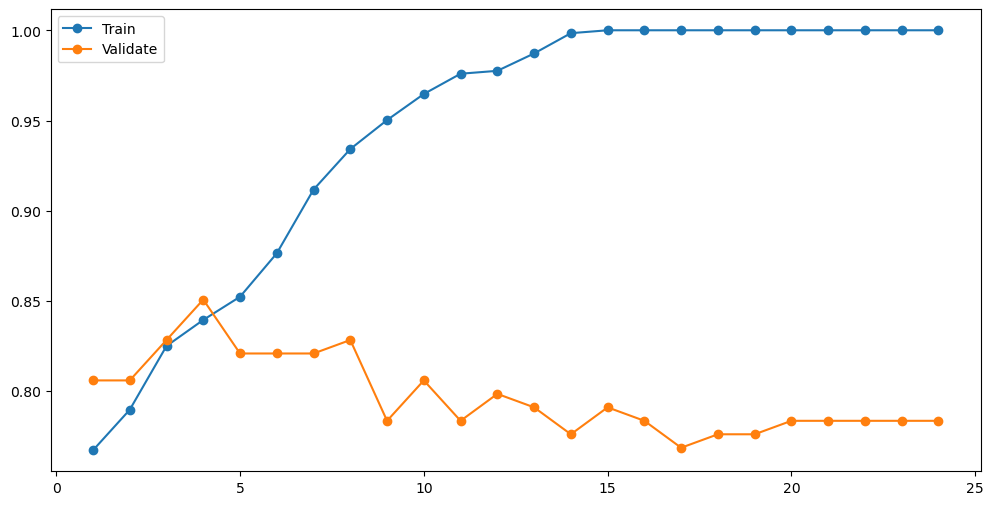

In [54]:
plt.figure(figsize=(12,6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o', label='Train')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o', label='Validate')
plt.legend()
plt.show()

4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [55]:
rf = RandomForestClassifier(max_depth=7, random_state=42, min_samples_leaf=4)

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=4, random_state=42)

In [65]:
y_pred = rf.predict(X_train)
print(rf.feature_importances_)

[0.11294958 0.12911506 0.0382431  0.04267329 0.20515993 0.01921715
 0.41874382 0.00890033 0.02499774]


In [66]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.48651236, 0.51348764],
       [0.85259667, 0.14740333],
       [0.12171144, 0.87828856],
       ...,
       [0.83212921, 0.16787079],
       [0.75120993, 0.24879007],
       [0.14554056, 0.85445944]])

In [67]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.87


In [68]:
print(confusion_matrix(y_train, y_pred))

[[362  22]
 [ 60 179]]


In [69]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       384
           1       0.89      0.75      0.81       239

    accuracy                           0.87       623
   macro avg       0.87      0.85      0.86       623
weighted avg       0.87      0.87      0.87       623



In [70]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_val, y_val)))

Accuracy of random forest classifier on test set: 0.84


In [71]:
rf.score(X_train, y_train)

0.8683788121990369

In [72]:
rf.score(X_val, y_val)

0.835820895522388

5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

A. The accuracy for the first model has a .96 on training and .79 on testing, with a .17 difference. The second model has an accuracy of .87 training and .84 testing, with a .03 difference. The first model performs better based on a .95 train vs a train of .86 on the second model. 

After making a few models, which one has the best performance (or closest metrics) on both train and validate?

A. Based on a difference between .17 on the first model and a .03 on the second model, the second model has the best performance. However, a max depth of three with a .003 difference has the closest metrics and will likely produce the best performance.

